# Keras 101 - Autoencoders for Anomaly Detection on images

In this Notebook, we will program simple Keras examples using the **Functional** and Sequential API.

### This will be an instance of unsupervised learning --> we do not need target labels

## Import the relevant libraries

In [1]:
# Utility libraries
import os
import random
from datetime import datetime

# Core libraries
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model  # Model used by Functional API
from tensorflow.keras.layers import Dense, Softmax, Lambda, Input  # Lambda and Input used by Functional API
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import optimizers

# For variational auto-encoder
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt # For plotting purposes


# Bug still not solved, resort to old keras module (see below)
# from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Use the above import when the bug is solved
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
# ------------------------------------------#

Using TensorFlow backend.


In [2]:
# Load the TensorBoard notebook extension (for visualization purposes)
%load_ext tensorboard

## MNIST Data Loading and Preprocessing

In [3]:
# Each MNIST image has shape (28,28)
mnist_img_rows, mnist_img_cols = 28, 28
dim_target = 10

# Load the MNIST dataset, which has already been splitted into training and test set
(mnist_train, mnist_y_train), (x_test, y_test) = mnist.load_data()

### What is the shape of our data?

In [4]:
print(f'Training set has {mnist_train.shape[0]} examples of {mnist_train.shape[1:]} features each value')
print(f'Training targets have shape {mnist_y_train.shape} i.e. we will predict a constant target value for each example')
print('')
print(f'Test set has {x_test.shape[0]} examples of {x_test.shape[1:]} features each value')
print(f'Test targets have shape {y_test.shape} i.e. we will predict a constant target value for each example')
print('')
print(f'Examples have type {mnist_train.dtype}, targets have type {mnist_y_train.dtype}')

Training set has 60000 examples of (28, 28) features each value
Training targets have shape (60000,) i.e. we will predict a constant target value for each example

Test set has 10000 examples of (28, 28) features each value
Test targets have shape (10000,) i.e. we will predict a constant target value for each example

Examples have type uint8, targets have type uint8


## Extract a validation set from the training set

In [5]:
def extract_subset(x_dataset, y_dataset, subset_percentage=10):
    # Choose a seed to obtain the same split
    random.seed(42)
    
    no_samples = x_dataset.shape[0]

    # Generate a list of indices
    indices = [i for i in range(no_samples)]

    # We want the x% of the training set to be used as a validation set
    no_subset_samples = int((no_samples/100)*subset_percentage)

    # In place shuffling of the data structure
    random.shuffle(indices)

    # Display the indices
    # print(f'Validation indices are: {indices[:no_subset_samples]}')

    # The subset will correspond to the first "no_subset_samples" shuffled indices
    x_subset = x_dataset[indices[:no_subset_samples], :]
    y_subset = y_dataset[indices[:no_subset_samples]]

    # The rest of the data will correspond to other shuffled indices
    new_x_dataset = x_dataset[indices[no_subset_samples:], :]
    new_y_dataset = y_dataset[indices[no_subset_samples:]]
    
    return (new_x_dataset, new_y_dataset), (x_subset, y_subset)

In [6]:
# Extract a validation set from the TRAINING set.
# You can also use this function to split you entire dataset into training, validation and test sets when these are not given.
(x_train, y_train), (x_valid, y_valid) = extract_subset(mnist_train, mnist_y_train, subset_percentage=10)

x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255
x_valid = x_valid.reshape(x_valid.shape[0], -1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

## Let's define a Variational Autoencoder

![VAE](https://i0.wp.com/mlexplained.com/wp-content/uploads/2017/12/VAE_complete.png?resize=1024%2C439&ssl=1)

### Image taken from [this blog post](https://mlexplained.com/2017/12/28/an-intuitive-explanation-of-variational-autoencoders-vaes-part-1/). 

### Now, let's define a function that provides the epsilon of the picture and multiplies it with Sigma (the variance associated with the latent representation). We are not interested in the math behind it here.

In [7]:
# reparameterization trick (no need to know the details)
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]  # get dimension of mini-batch
    dim = K.int_shape(z_mean)[1]  # get dimension of each z

    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))

    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Define the VAE and its hyper-parameters

In [99]:
intermediate_dim = 256  # Hidden units of the MLP
batch_size = 128
latent_dim = 2  # Dimension of the compressed input encoding our digit
epochs = 50
learning_rate = 1e-3

# ----------------------- Encoder ------------------------- #

inputs = Input(shape=(mnist_img_cols*mnist_img_rows,), name='encoder_input')  #  The image is the input of our Encoder 

h = Dense(intermediate_dim, activation='relu')(inputs)  # A Dense layer compresses the input

# First Output of the encoder
z_mean = Dense(latent_dim, activation='linear', name='z_mean')(h)  # Further compression into latent space for mean

# Second Output of the encoder
z_log_var = Dense(latent_dim, name='z_log_var')(h)  # Further compression into latent space for log_var

# Third Output of the encoder
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate the Encoder as a Model, by specifying its inputs and outputs
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# -------------------------------------------------------- #

# ----------------------- Decoder ------------------------- #

latent_inputs = Input(shape=(latent_dim,), name='z')

h = Dense(intermediate_dim, activation='relu')(latent_inputs)

outputs = Dense(mnist_img_rows*mnist_img_cols, activation='sigmoid')(h)

# Instantiate the Decoder as a Model, by specifying its inputs and outputs
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Instantiate VAE model 
outputs = decoder(encoder(inputs)[2])

# -------------------------------------------------------- #

vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 256)          200960      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_15[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_15[0][0]                   
____________________________________________________________________________________________

### This model needs a specific loss to be defined. Let's see how we can extend a loss function!

In [100]:
def add_vae_loss(vae, encoder_inputs, decoder_outputs, z_mean, z_log_var, original_dim):
    
    reconstruction_loss = losses.mse(inputs, outputs)  # Start with the Mean Squared Error
    reconstruction_loss *= original_dim  # we will average later! This is now the "Squared Error"
    
    # Compute the KL divergence (no need to know the math details here), which is our additional regularization term
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    # Recompute the mean (over the examples) of the reconstruction error + regularization term
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    
    # Add the loss to the model before compiling it
    vae.add_loss(vae_loss)    

## Prepare the model for training

In [101]:
# Let's prepare the VAE loss, which is a reconstruction error + a regularization term
add_vae_loss(vae, inputs, outputs, z_mean, z_log_var, original_dim=mnist_img_rows*mnist_img_cols)
vae.compile(optimizer=optimizers.Adam(lr=learning_rate))  # Optimizer

In [102]:
# Clear any logs from previous runs
!rm -rf ./logs_vae

# Set up a log folder in which we will store the output to be displayed on TensorBoard
logdir = "logs_vae/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Chekpoint path for storing our model
checkpoint_path = "checkpoints/vae/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Train the Model!
# Note: fit has also the chance to specify a validation split percentage
print('# Fit model on training data')
history = vae.fit(x_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=(x_valid, None),  # None because we do not need labeled data!! It's unsupervised training!
                  callbacks=[tensorboard_callback])

# Fit model on training data
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 48us/sample - loss: 55.9049 - val_loss: 45.9669
Epoch 2/50
54000/54000 [==============================] - 2s 41us/sample - loss: 44.6235 - val_loss: 43.3842
Epoch 3/50
54000/54000 [==============================] - 2s 40us/sample - loss: 43.1792 - val_loss: 42.6205
Epoch 4/50
54000/54000 [==============================] - 2s 41us/sample - loss: 42.5485 - val_loss: 42.0996
Epoch 5/50
54000/54000 [==============================] - 2s 40us/sample - loss: 42.0455 - val_loss: 41.6462
Epoch 6/50
54000/54000 [==============================] - 2s 39us/sample - loss: 41.5883 - val_loss: 41.2175
Epoch 7/50
54000/54000 [==============================] - 2s 39us/sample - loss: 41.2148 - val_loss: 40.9356
Epoch 8/50
54000/54000 [==============================] - 2s 39us/sample - loss: 40.8974 - val_loss: 40.6422
Epoch 9/50
54000/54000 [==========================

In [103]:
# Visualize your model
%tensorboard --logdir {logdir}

In [104]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

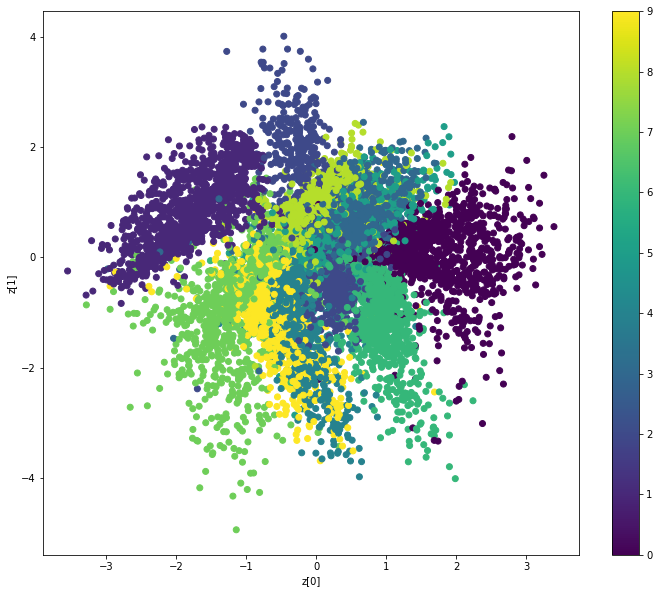

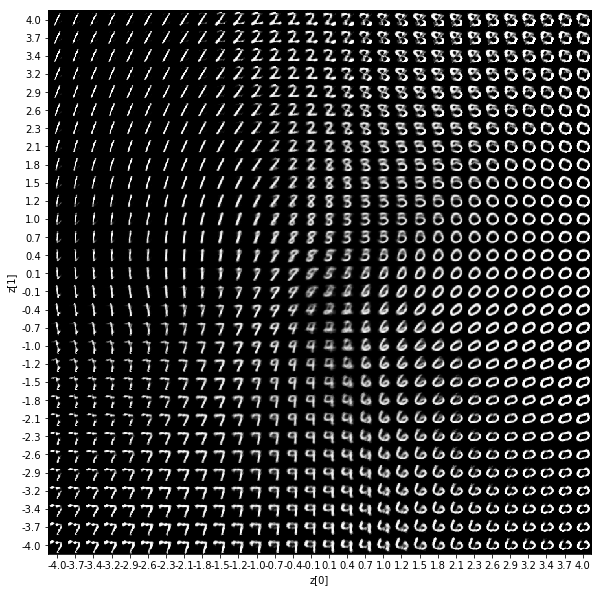

In [105]:
plot_results((encoder, decoder),
             (x_test, y_test),
             batch_size=batch_size,
             model_name="vae_mlp")

# Use the reconstruction Loss to perform anomaly detection

## Idea: if reconstruction loss is above a certain threshold, then we consider the input as an anomaly!

In [106]:
reconstructed_test = vae.predict(x_test)  # let's reconstruct the test input

(array([ 961., 1487., 3355., 2296., 1141.,  453.,  195.,   76.,   23.,
          13.]),
 array([0.00347431, 0.01688014, 0.03028597, 0.0436918 , 0.05709763,
        0.07050346, 0.08390929, 0.09731512, 0.11072095, 0.12412678,
        0.1375326 ], dtype=float32),
 <a list of 10 Patch objects>)

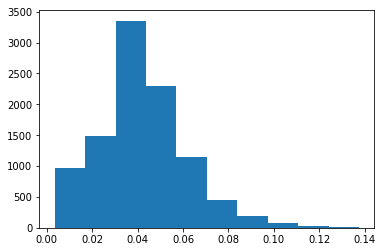

In [107]:
# Compute the squared error for each example
squared_error = np.sum(np.power((x_test - reconstructed_test), 2), axis=1)/(mnist_img_cols*mnist_img_rows)

# Plot the histogram of the reconstruction errors per image
plt.hist(squared_error)

## 0.07 seems like a good threshold to decide whether an input is an anomaly or not!

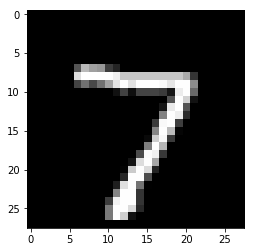

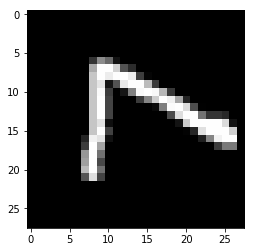

In [119]:
# Set the desired threshold
threshold = 0.07

# Now let's perturbate a test example
sample = x_test[0]
plt.imshow(np.reshape(sample, (mnist_img_rows, mnist_img_cols)), cmap='gray')

#perturbated_sample = sample + np.random.randint(0,2, size=(mnist_img_rows*mnist_img_cols))
perturbated_sample = np.reshape(
                            np.rot90(
                                np.reshape(sample, (mnist_img_rows, mnist_img_cols)),  # convert into matrix
                            k=1),
                            (mnist_img_rows*mnist_img_cols,)  # convert back to vector
                    )

plt.figure()
plt.imshow(np.reshape(perturbated_sample, (mnist_img_rows, mnist_img_cols)), cmap='gray')

# Add the "batch" dimension
perturbated_sample = np.expand_dims(perturbated_sample, axis=0)

Reconstruction error is 0.07484196871519089, is this an anomaly? --> True


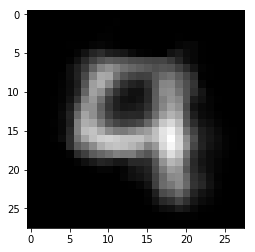

In [120]:
reconstructed_sample = vae.predict(perturbated_sample)  # let's reconstruct the test input

# Compute the squared error for each example
squared_error = np.sum(np.power((perturbated_sample - reconstructed_sample), 2), axis=1)/(mnist_img_cols*mnist_img_rows)

print(f'Reconstruction error is {squared_error[0]}, is this an anomaly? --> {bool(squared_error > threshold)}')

plt.imshow(np.reshape(reconstructed_sample, (mnist_img_rows, mnist_img_cols)), cmap='gray')

# Exercise time! Change the model above to implement a Deep Neural Autoencoder!